In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import unicodedata

DATASET_PATH = 'data/errores.csv'

%matplotlib inline  

# Análisis de errores de traducción

Propuesta de metodología para formalizar la traducción de textos a partir de la identificación de tipos de error.
```
Antonio G.B. <argolide.90@gmail.com>
    - Evaluador de la traducción.
Samuel M.H. <samuel.mh@gmail.com>
    - Autor de este cuaderno y asesor.
```

## Metodología
1. Se evaluará la obra y el traductor puntuará cada error encontrado de 0 a 10 según la gravedad.
    Cada error está identificado unívocamente por el número de página, la viñeta y el número de error.
1. Se identificarán los tipos de error y se calcularán sus medias. Si la dispersión de esta puntuación es coherente (homocedasticidad y baja desviación típica), se aceptará la media como valor representativo para ese tipo de error. Si no fuera así, habría que hallar los porqués y posiblemente subdividir ese tipo de error hasta alcanzar unos parámetros aceptables.
1. Se reevaluará el trabajo con las nuevas puntuaciones a partir de los estimadores de error obtenidos para cada tipo de error y se demostrará que esta nueva puntuación está muy cerca de la que le da el autor.


## Objetivos
Proponer un marco de trabajo que disminuya la variabilidad a la hora de puntuar una traducción y que la nota otorgada sea lo más independiente posible de factores humanos como: el traductor, el estado de ánimo, o la experiencia (hasta cierto punto). De esta forma, ante una traducción se puede tener una valoración absoluta de su calidad.

Esto permitiría, comparar absolutamente:
* Profesionales de la traducción (establecer un ránking de traductores o empresas).
* Diferentes ediciones de una obra traducida.

## Conjunto de datos

In [2]:
errors = pd.read_csv(DATASET_PATH, sep=';', encoding='ISO-8859-2')

In [3]:
errors.columns = [
    'PAGE_ID', 'BOX_ID', 'ERROR_ID', 'BOX_POINTS', 'ERROR_TYPE', 'ERROR_POINTS', 'COMMENTS'
]
errors['ERROR_TYPE'] = errors['ERROR_TYPE'].apply(lambda x: unicodedata.normalize('NFKD', x.lower()).encode('ASCII', 'ignore'))

In [4]:
errors

,PAGE_ID,BOX_ID,ERROR_ID,BOX_POINTS,ERROR_TYPE,ERROR_POINTS,COMMENTS
0,7,1,1,10,cero sin,-2,NaN
1,8,1,1,8,error de matiz,1,En el primer bocadillo no utiliza en ningún mo...
2,8,1,2,8,error de significado,1,En la segunda parte del bocadillo no expresa l...
3,8,2,1,8,error de matiz,1,El significado final del primer bocadillo corr...
4,8,2,2,8,error de referencia,1,El segundo bocadillo hace referencia a Kenshin...
5,8,3,1,5,invencion,5,El traductor se inventa la oración por complet...
6,8,4,1,10,cero,-1,NaN
7,9,1,1,10,cero,-1,NaN
8,9,2,1,7,falta palabra,1,En el primer bocadillo falta la referencia al ...
9,9,2,2,7,error de matiz,2,En la traducción habla de la posibilidad de at...


Descripción de errores:
* error contextual: 
* error de matiz: 
* error de nombre': 
* error de referencia': 
* error de significado': 
* error historico': 
* falta palabra': 
* invencion:
* cero: no hay error.
* cero sin: no hay error posible al no haber texto.

In [5]:
print "Páginas procesadas: {}".format(len(errors['PAGE_ID'].unique()))

Páginas procesadas: 101


### Tipos de error detectados

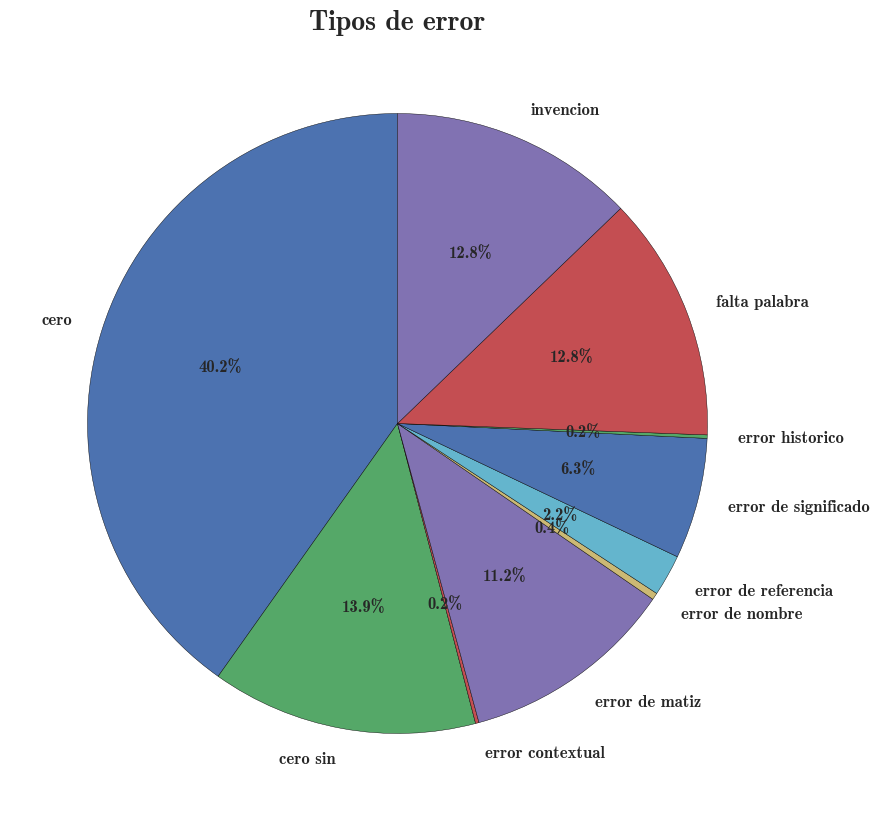

In [6]:
error_types = errors.groupby('ERROR_TYPE')
pd.Series(error_types.count()['ERROR_POINTS'], name='').plot.pie(figsize=(10,10), autopct='%1.1f%%',fontsize=12, startangle=90).set_title('Tipos de error', fontsize=20)

## Análisis por tipo de error (errores auténticos)
Por el momento se ignoran los tipos de error 'cero' y 'cero sin'. Sólo se tiene en cuenta los errores que restan nota.

In [7]:
error_types = errors[errors['ERROR_POINTS']>0].groupby('ERROR_TYPE')
print "Número de errores detectados: {}".format(len(errors[errors['ERROR_POINTS']>0]))

Número de errores detectados: 255


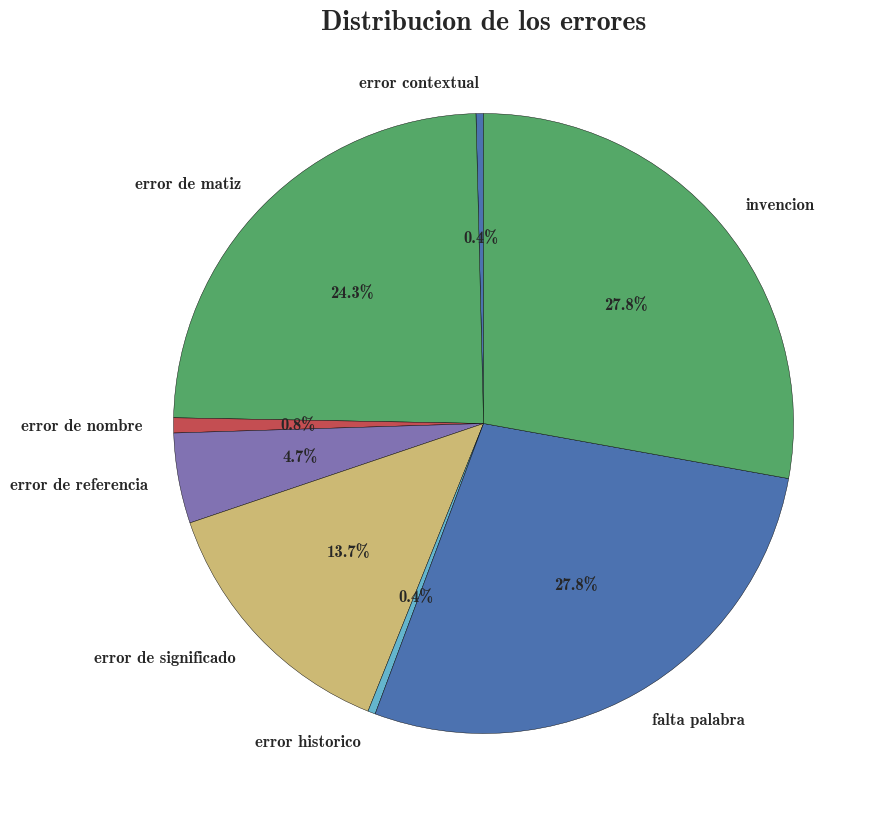

In [8]:
pd.Series(error_types.count()['ERROR_POINTS'], name='').plot.pie(figsize=(10,10), autopct='%1.1f%%',fontsize=12, startangle=90).set_title('Distribucion de los errores', fontsize=20)

In [9]:
def plot_error(error):
    error_stats = error.describe()
    print "\tCantidad: {}".format(int(error_stats['count']))
    print "\tMedia: {}".format(error_stats['mean'])
    print "\tValor mínimo: {}".format(error_stats['min'])
    print "\tMediana: {}".format(error_stats['50%'])
    print "\tValor máximo: {}".format(error_stats['max'])
    print "\tDesviación típica: {}".format(error_stats['std'])
    if error_stats['count']>10:
        plt.clf()
        sns.distplot(error,norm_hist=False, bins=11, kde=False,  axlabel="Puntos", hist_kws={"range": [0,11]}).set_title('Histograma')
        plt.xticks(range(11))
        axes = plt.gca()
        axes.set_xlim([-0.5,11.5])
        plt.show()
        plt.clf()
        if error_stats['std']>0:
            sns.distplot(error,fit=norm, bins=11, kde=False,  axlabel="Puntos", hist_kws={"range": [0,11]}).set_title('Histograma normalizado')
            axes = plt.gca()
            axes.set_xlim([-0.5,11.5])
            axes.set_ylim([0,1])
            avg = error_stats['mean']
            plt.xticks(range(11))
            plt.plot((avg, avg), (0, 1), 'k-')
            plt.show()



Tipo de error: error contextual
	Cantidad: 1
	Media: 5.0
	Valor mínimo: 5.0
	Mediana: 5.0
	Valor máximo: 5.0
	Desviación típica: nan


Tipo de error: error de matiz
	Cantidad: 62
	Media: 1.67741935484
	Valor mínimo: 1.0
	Mediana: 2.0
	Valor máximo: 5.0
	Desviación típica: 0.825300611866


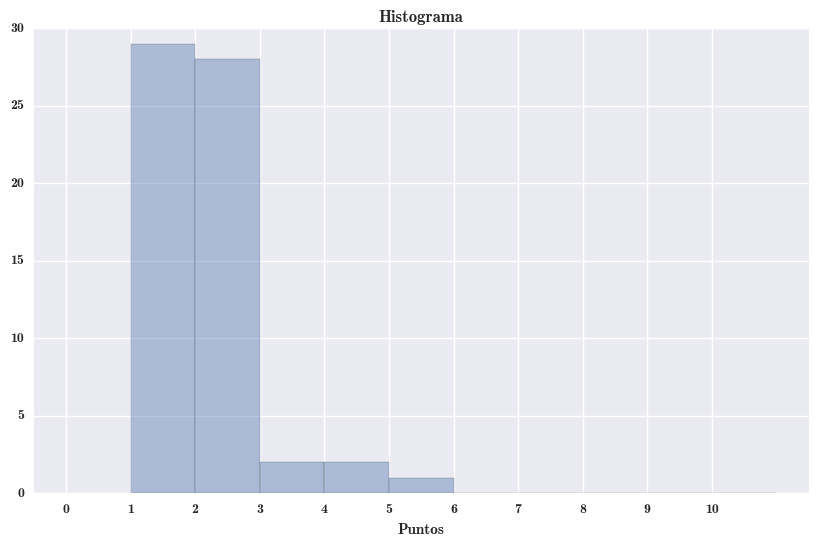

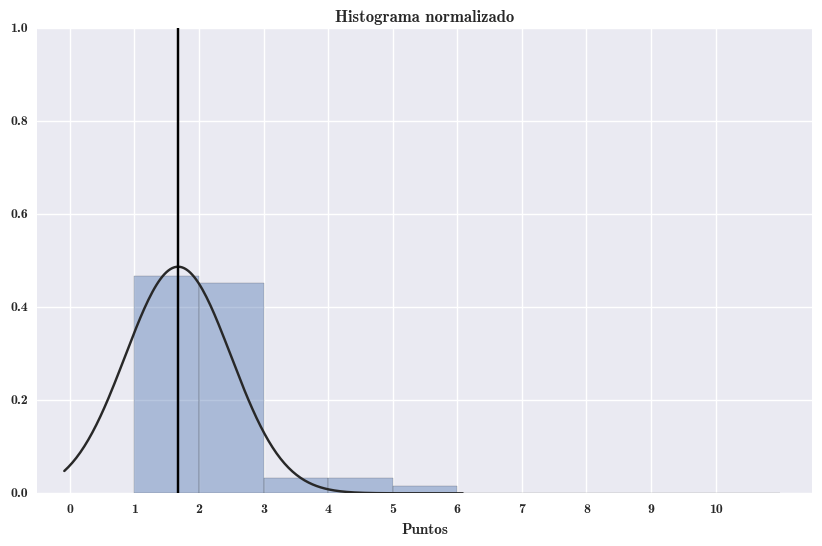



Tipo de error: error de nombre
	Cantidad: 2
	Media: 1.0
	Valor mínimo: 1.0
	Mediana: 1.0
	Valor máximo: 1.0
	Desviación típica: 0.0


Tipo de error: error de referencia
	Cantidad: 12
	Media: 1.5
	Valor mínimo: 1.0
	Mediana: 1.0
	Valor máximo: 3.0
	Desviación típica: 0.674199862463


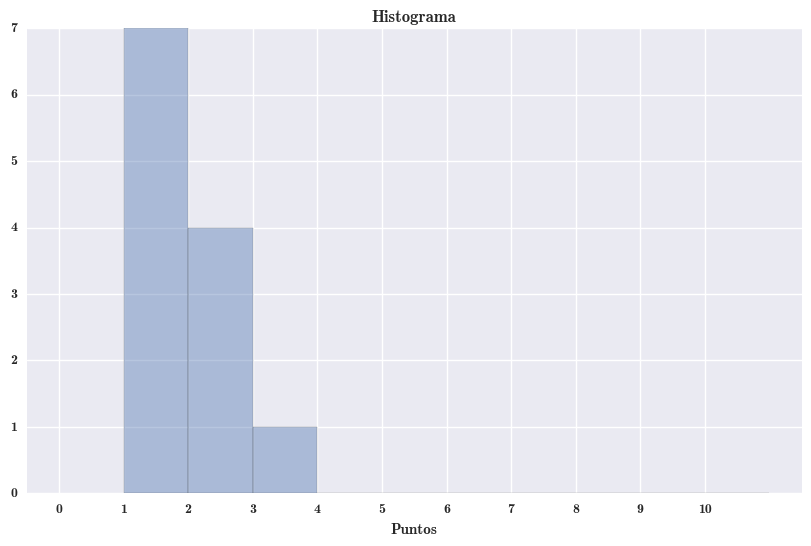

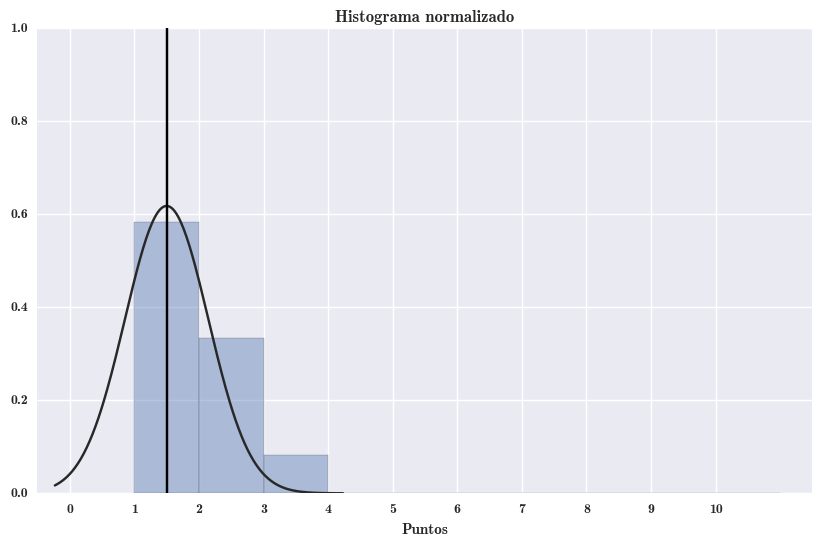



Tipo de error: error de significado
	Cantidad: 35
	Media: 1.62857142857
	Valor mínimo: 1.0
	Mediana: 1.0
	Valor máximo: 3.0
	Desviación típica: 0.731063459292


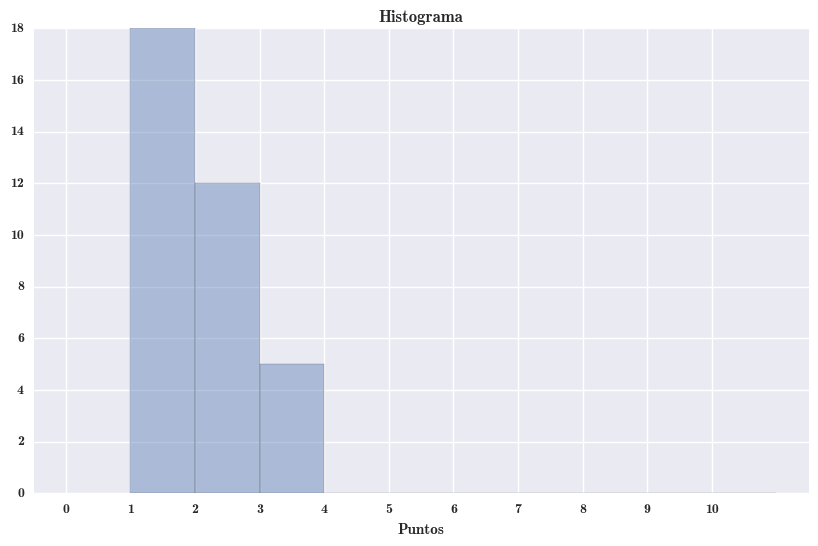

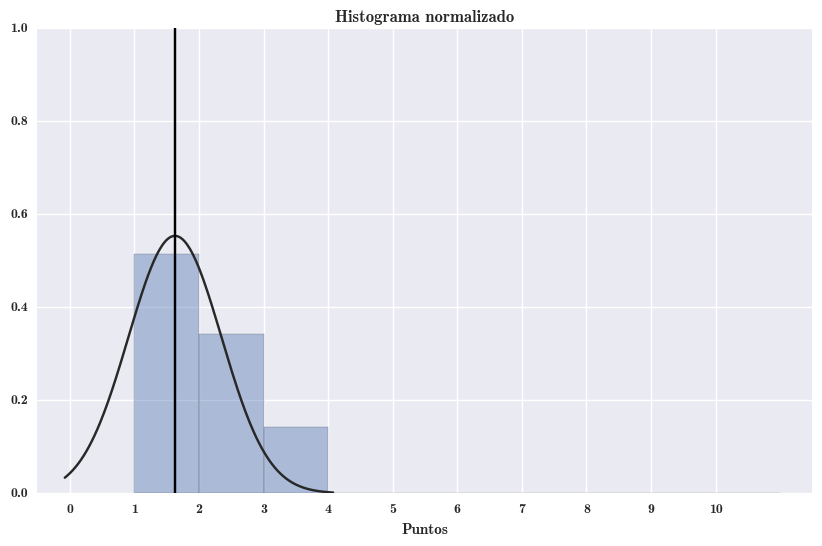



Tipo de error: error historico
	Cantidad: 1
	Media: 2.0
	Valor mínimo: 2.0
	Mediana: 2.0
	Valor máximo: 2.0
	Desviación típica: nan


Tipo de error: falta palabra
	Cantidad: 71
	Media: 1.64788732394
	Valor mínimo: 1.0
	Mediana: 2.0
	Valor máximo: 3.0
	Desviación típica: 0.65680159103


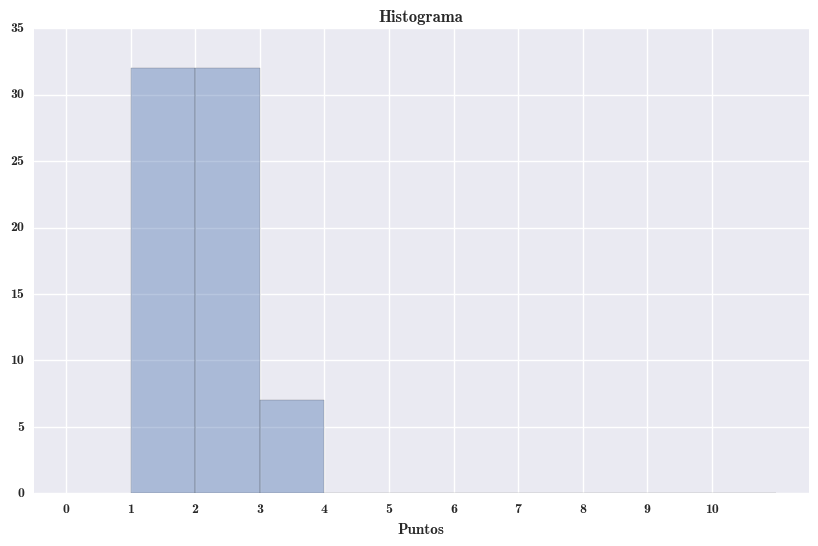

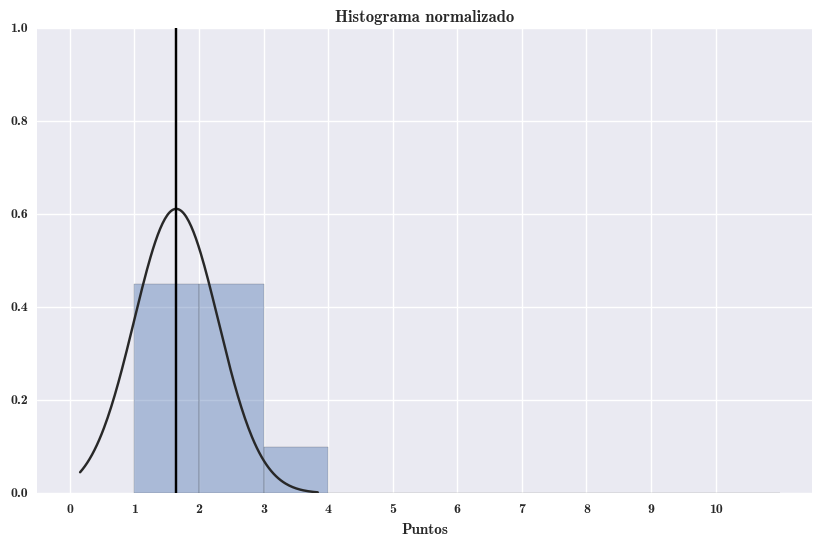



Tipo de error: invencion
	Cantidad: 71
	Media: 4.3661971831
	Valor mínimo: 1.0
	Mediana: 3.0
	Valor máximo: 10.0
	Desviación típica: 3.16787191579


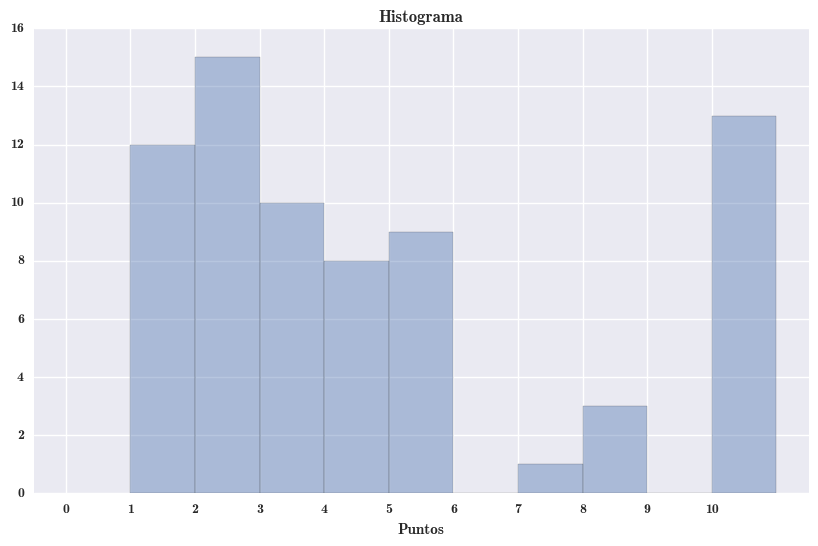

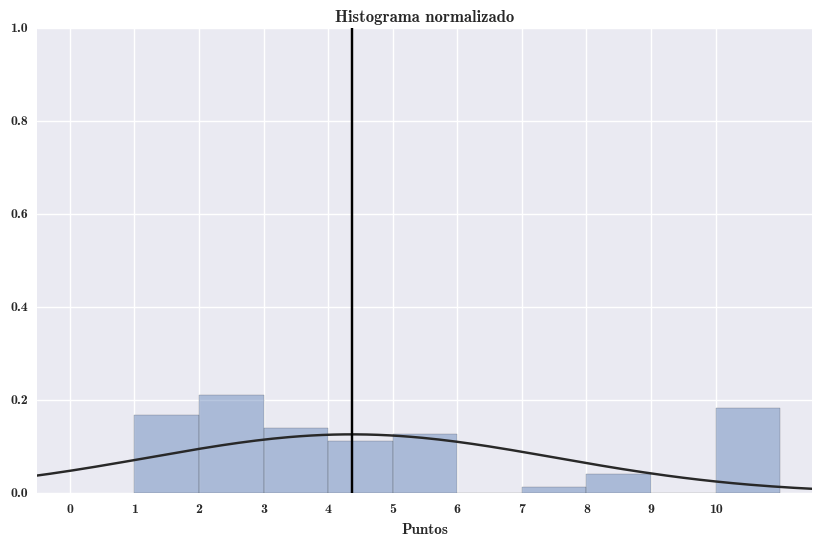

In [10]:
sns.set(rc={"figure.figsize": (10, 6)})
for error_key in sorted(error_types.groups.keys()):
    print "\n\nTipo de error: {}".format(error_key)
    error = error_types['ERROR_POINTS'].get_group(error_key)
    plot_error(error)    

### Refinar tipo de error: invencion

En el paso anterior, se aprecia que el tipo de error 'invencion' tiene una dispersión muy alta. La hipótesis es que hay varios tipos de error mezclados en este supertipo. En una solución de compromiso, se procede a partirlo en 4 (máximo número aceptable de grupos que minimiza la dispersión) subgrupos según la severidad del error.
* invencion leve: 0.00-2.99 ptos.
* invencion moderada: 3.00-5.99 ptos.
* invencion grave: 6-8.99
* invencion muy grave: 9.00-10.00 ptos

In [11]:
def refine_error(row):
    if row['ERROR_TYPE'] == 'invencion':
        points = row['ERROR_POINTS']
        if points <= 3:
            return 'invencion leve'
        elif points <= 6:
            return 'invencion moderada'
        elif points <= 9:
            return 'invencion grave'
        else:
            return 'invencion muy grave'
    else:
        return row['ERROR_TYPE']

In [12]:
errors['ERROR_TYPE_EXTENDED'] = errors.apply(func=refine_error, axis=1)

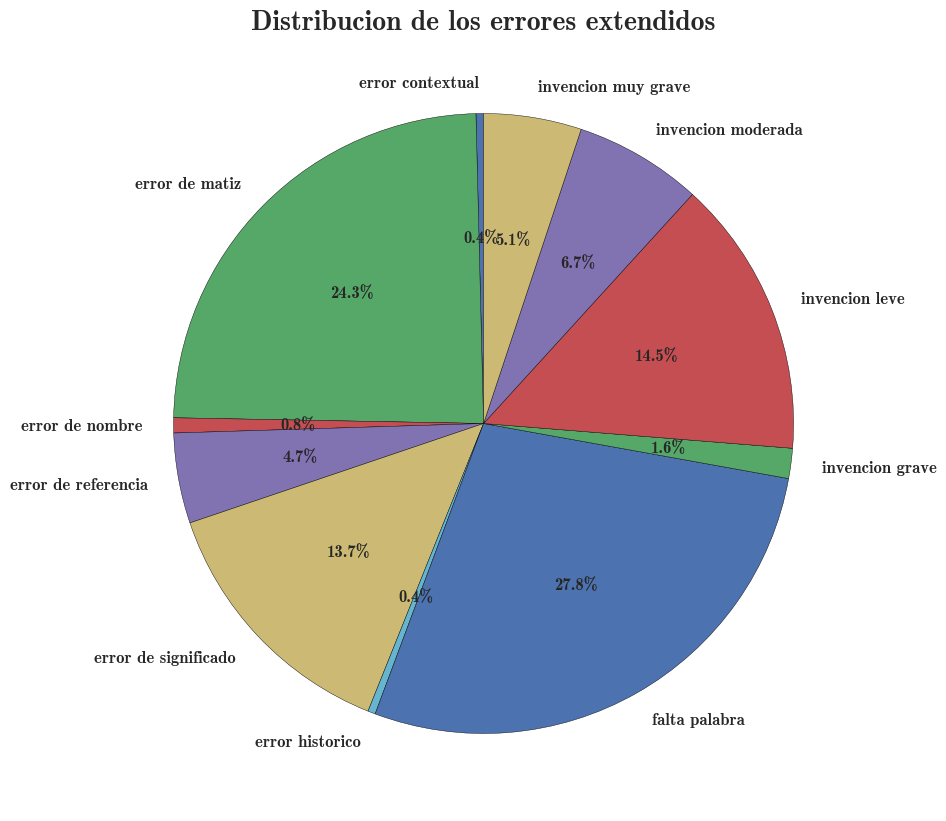

In [13]:
error_types_extended = errors[errors['ERROR_POINTS']>0].groupby('ERROR_TYPE_EXTENDED')
pd.Series(error_types_extended.count()['ERROR_POINTS'], name='').plot.pie(figsize=(10,10), autopct='%1.1f%%',fontsize=12, startangle=90).set_title('Distribucion de los errores extendidos', fontsize=20)



Tipo de error: invencion leve
	Cantidad: 37
	Media: 1.94594594595
	Valor mínimo: 1.0
	Mediana: 2.0
	Valor máximo: 3.0
	Desviación típica: 0.779812867365


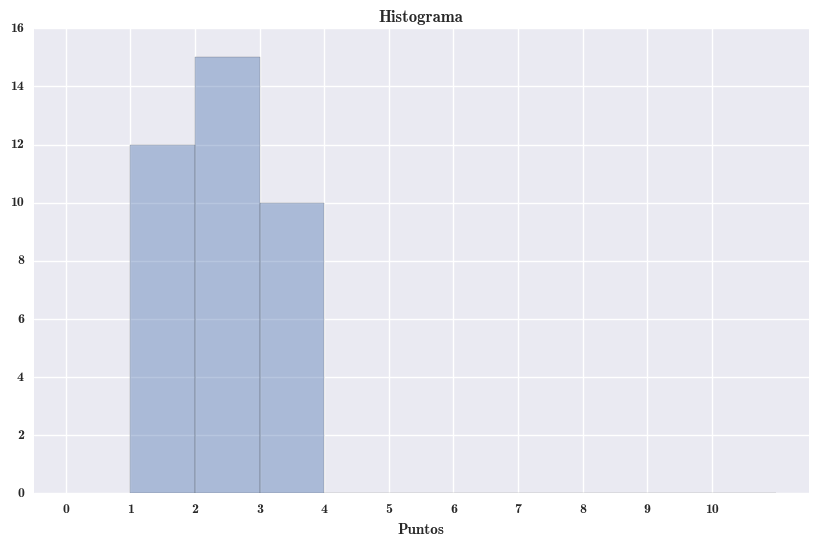

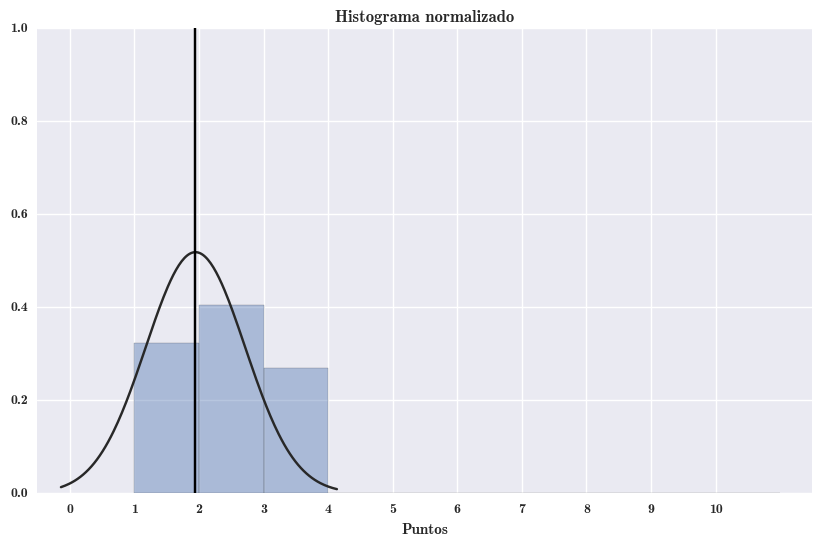



Tipo de error: invencion moderada
	Cantidad: 17
	Media: 4.52941176471
	Valor mínimo: 4.0
	Mediana: 5.0
	Valor máximo: 5.0
	Desviación típica: 0.514495755428


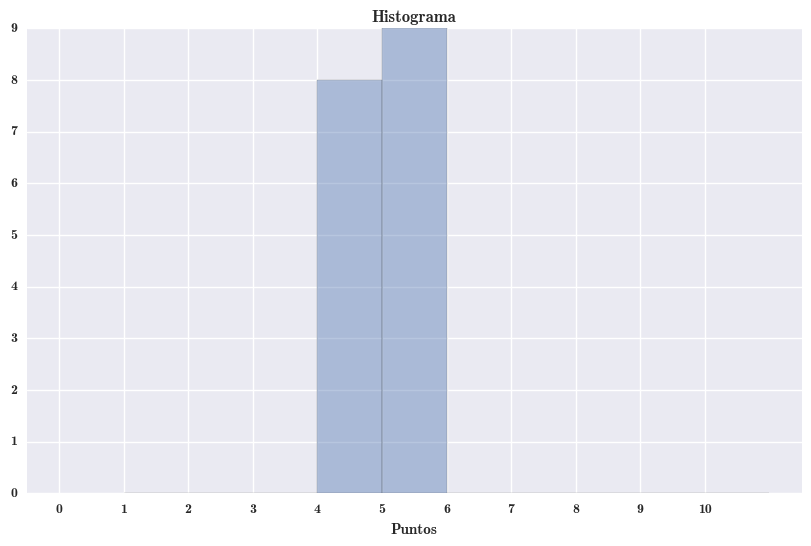

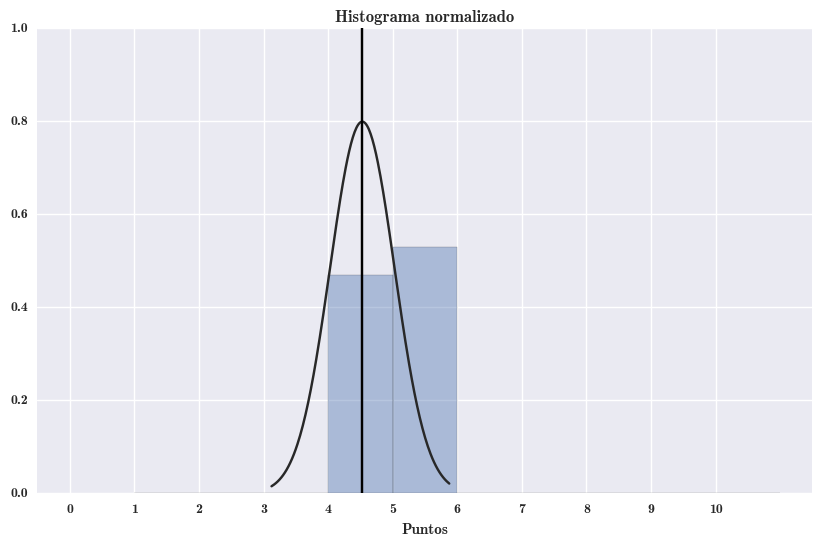



Tipo de error: invencion grave
	Cantidad: 4
	Media: 7.75
	Valor mínimo: 7.0
	Mediana: 8.0
	Valor máximo: 8.0
	Desviación típica: 0.5


Tipo de error: invencion muy grave
	Cantidad: 13
	Media: 10.0
	Valor mínimo: 10.0
	Mediana: 10.0
	Valor máximo: 10.0
	Desviación típica: 0.0


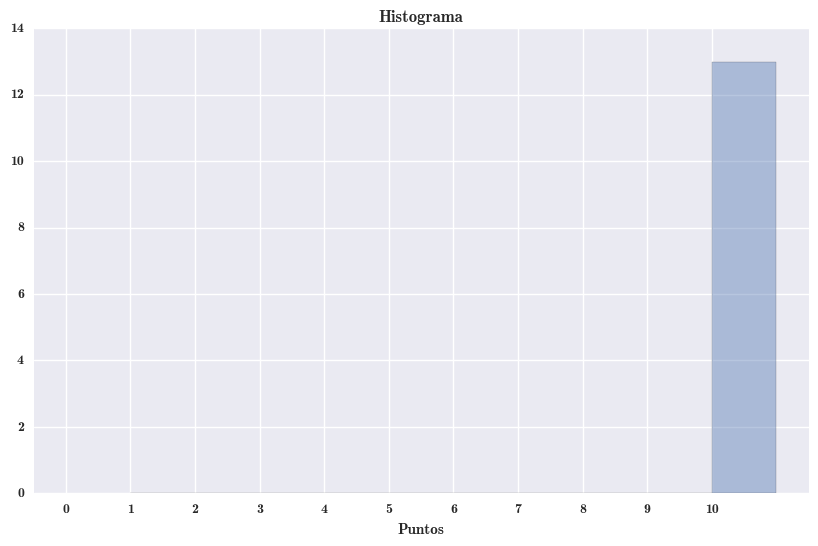

In [14]:
sns.set(rc={"figure.figsize": (10, 6)})
for error_key in ['invencion leve','invencion moderada','invencion grave','invencion muy grave']:
    print "\n\nTipo de error: {}".format(error_key)
    error = error_types_extended['ERROR_POINTS'].get_group(error_key)
    plot_error(error)    

## Ponderación del tipo de error

Recopilación de la sección anterior. Tipos de error y lo que penalizan la traducción (medias).

In [15]:
type_avg = dict((error_types_extended.mean()['ERROR_POINTS']))
type_avg

{'error contextual': 5.0,
 'error de matiz': 1.6774193548387097,
 'error de nombre': 1.0,
 'error de referencia': 1.5,
 'error de significado': 1.6285714285714286,
 'error historico': 2.0,
 'falta palabra': 1.647887323943662,
 'invencion grave': 7.75,
 'invencion leve': 1.9459459459459461,
 'invencion moderada': 4.5294117647058822,
 'invencion muy grave': 10.0}

## Calidad de la obra

In [16]:
data_possible_errors = errors[errors['ERROR_POINTS']>-2]
data_possible_errors['ERROR_POINTS'] = data_possible_errors['ERROR_POINTS'].apply(lambda x: 0 if x<0 else x)
box_groups = data_possible_errors.groupby(('PAGE_ID','BOX_ID'))
print "Número de viñetas con posible error: {}".format(len(box_groups))

Número de viñetas con posible error: 394


### Puntuación media por viñeta

#### Obtenida a través de las medias

In [17]:
data_possible_errors['ERROR_POINTS_AVG'] = data_possible_errors['ERROR_TYPE_EXTENDED'].apply(lambda x: type_avg.get(x,0))
10-box_groups.mean()['ERROR_POINTS_AVG'].mean()

8.8332814699195765

#### Otorgada por el traductor

In [18]:
10-box_groups.mean()['ERROR_POINTS'].mean()

8.7928510998307949

No son iguales pero se parecen mucho. Es un resultado aceptable para la cantidad de datos.

Cuanto más grande es la diferencia, menos coherente es el evaluador en su trabajo (variabilidad humana, mala identificación de los tipos de error, etc).

### Distribución de los errores

#### Cuantitativa

Cuántos errores hay entre todos los posibles.

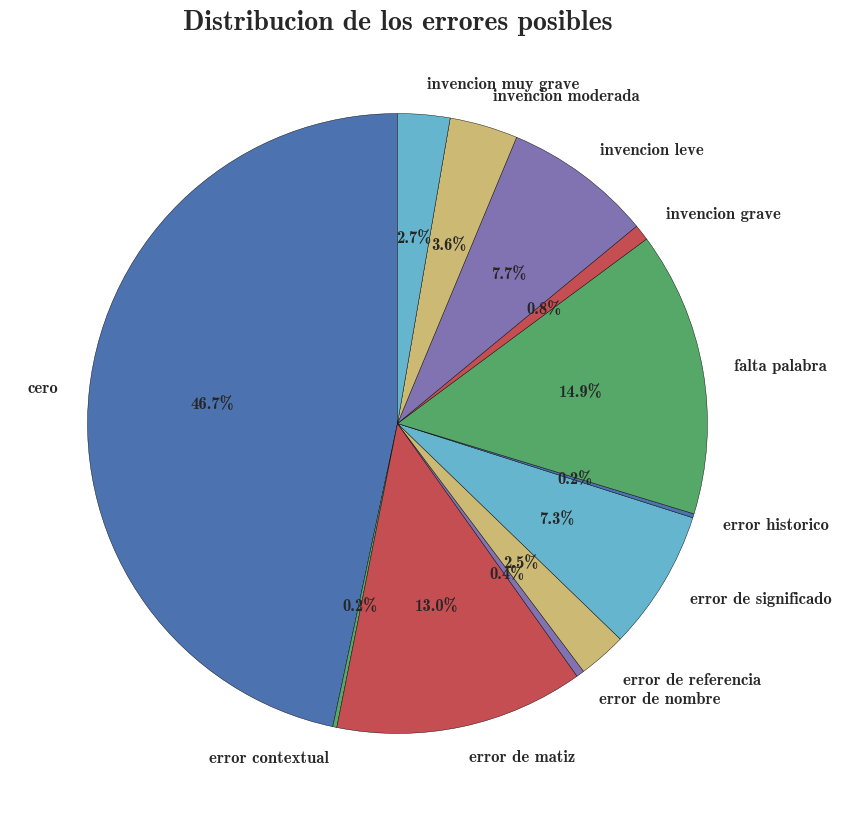

In [19]:
error_groups = data_possible_errors.groupby('ERROR_TYPE_EXTENDED')
pd.Series(error_groups.count()['ERROR_POINTS'], name='').plot.pie(figsize=(10,10), autopct='%1.1f%%',fontsize=12, startangle=90).set_title('Distribucion de los errores posibles', fontsize=20)

### Cualitativa

Cuánto afecta cada tipo de error a la nota global.

*Nota*: un error afecta a la nota global según su media calculada (estimación) y su frecuencia.

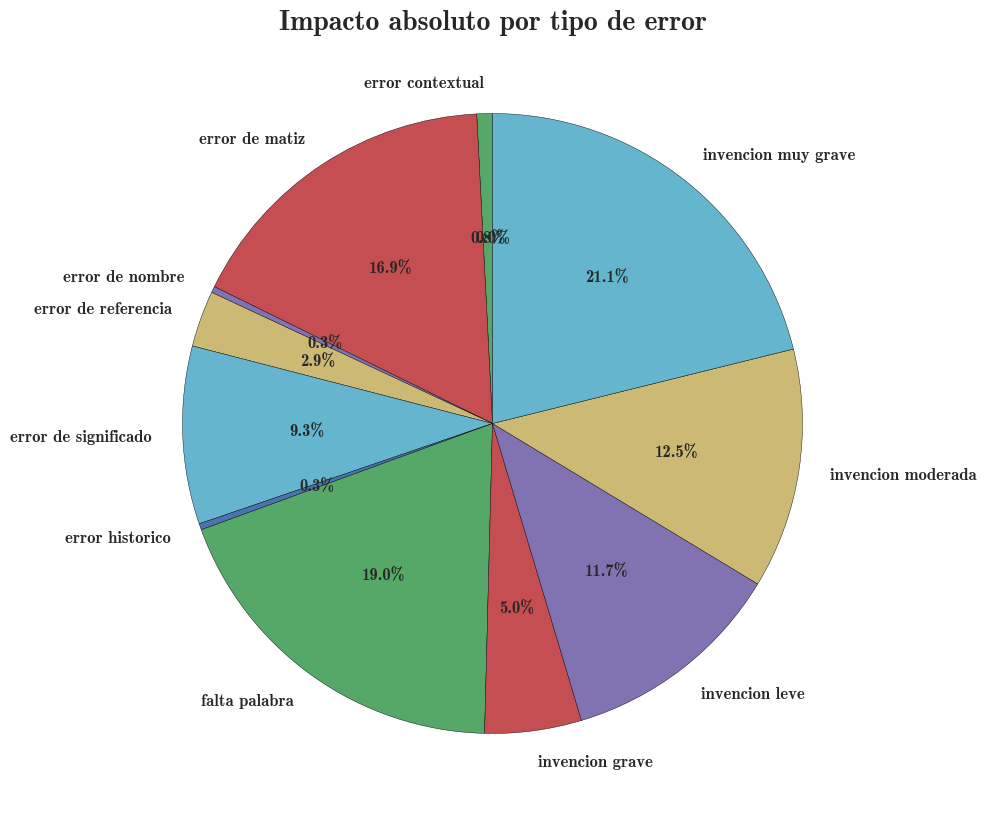

In [20]:
pd.Series(error_groups['ERROR_POINTS_AVG'].mean()*error_groups['ERROR_POINTS_AVG'].count(), name='').plot.pie(figsize=(10,10), autopct='%1.1f%%',fontsize=12, startangle=90).set_title('Impacto absoluto por tipo de error', fontsize=20)

## Trabajo futuro
* Mejorar la estimación de los tipos de error (calibración).
    * Con más obras del mismo tipo se reduce la variabilidad entre obras. En este caso "mangas".
    * Con más evaluadores se reduce la variabilidad entre evaluadores.
        * Se pueden calcular los segos de cada evaluador.
* Extender la metodología a otros tipos de obras literarias: novelas, folletos, webs, etc.
* Conseguir que terceras partes apliquen la metodología y la validen.
